In [1]:
from integsol.mesh.mesh import Mesh
from integsol.compute.vectors import VectorField
from integsol.compute.operators import (
    IntegralConvolutionOperator as ICO,
    CrossProductOperator as CPO,
)
from integsol.compute.kernels import demagnetization_tensor_kernel as dtk
import numpy as np
from torch.linalg import eig
from torch import (
    Tensor,
    dot,
    matmul,
    mv,
)


In [2]:
M_s = 1.45 * 1e4
gamms = 2.25 * 1e4

In [3]:
mesh = Mesh.read(path="/home/aluatar/integsol/test_inputs/mesh_coerse.mphtxt")

Begin calculation of elements measures.
Calculate measures for vtx type of elements
Calculate measures for edg type of elements
Progress: 98.68%

Calculate measures for tri type of elements
Progress: 99.85%

Calculate measures for tet type of elements
Progress: 99.97%

Calculation of measures of all elements finished in 32.57627463340759 seconds.


In [4]:
centers = mesh.elements_centers['tet'].T
volumes = mesh.elements_measures['tet']


In [5]:
dtk(centers.T[5], centers.T[90]) * volumes[90]

array([[ 0.02067778,  0.02351874,  0.00247972],
       [ 0.02351874, -0.04781147, -0.00799076],
       [ 0.00247972, -0.00799076,  0.02713369]])

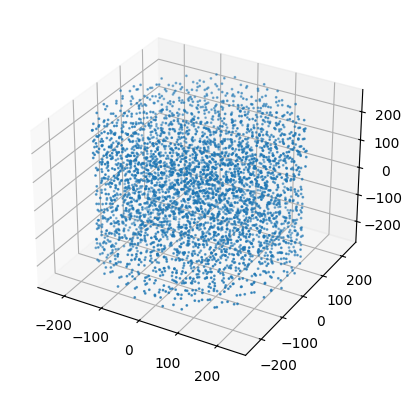

In [6]:
import matplotlib.pyplot as plt 
import numpy as np

fig = plt.figure()

ax = fig.add_subplot(projection='3d')

ax.scatter(xs=np.float64(centers[0]), ys=np.float64(centers[1]), zs=np.float64(centers[2]), s=1)

In [ ]:
coord_to_write = []
X, Y, Z =[], [], []
for coordinate in centers.T:
    X.append(coordinate[0])
    Y.append(coordinate[1])
    Z.append(coordinate[2])

coord_to_write = zip(X,Y,Z)

from datetime import datetime
import csv

with open(F"/home/aluatar/integsol/outputs/interpolation_coordinates/coordinates_{datetime.now()}.txt", 'w') as _csv:
    writer = csv.writer(_csv, delimiter='\t')
    writer.writerows(coord_to_write)

In [7]:
M0 = VectorField.read_to_mesh(
    path="/home/aluatar/integsol/test_inputs/magnetization_coerse.txt",
    mesh=mesh,
    dim=3)

_M0 = np.round(M0.vectorize(),4)

In [8]:
M0_cpo = CPO(
    mesh=mesh,
    left_vector= _M0
)

M0_times_ = M0_cpo.to_mesh_matrix()
M0_times_

tensor([[ 0.0000e+00, -1.0000e+00, -0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.0000e+00, -0.0000e+00, -0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
         -1.0000e+00, -0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
         -0.0000e+00, -1.0000e-04],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          1.0000e-04,  0.0000e+00]])

In [9]:
ico = ICO(kernel=dtk)
int_G_ = ico.to_mesh_matrix(mesh=mesh)

Begin placement of operator on mesh elements' centers.
Progress: 99.97%

Mesh matric of the operator generated in 499.268572807312 seconds.


In [10]:
Hd = VectorField(mesh=mesh)

_Hd = mv(int_G_, _M0)
Hd.devectorize(_Hd)
_Hd

tensor([-8.5505,  2.0659,  0.7454,  ..., -7.5870,  1.5432, -1.0416])

In [11]:
H0 = VectorField(
    mesh=mesh,
    values=np.array([[0,0,5e5 / M_s] for _ in range(len(mesh.elements_centers['tet']))])
)
_H0 = H0.vectorize()
_H0

tensor([ 0.0000,  0.0000, 34.4828,  ...,  0.0000,  0.0000, 34.4828])

In [12]:
H0_cpo = CPO(mesh=mesh, left_vector=_H0)
H0_times_ = H0_cpo.to_mesh_matrix()
H0_times_

tensor([[  0.0000, -34.4828,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [ 34.4828,   0.0000,  -0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [ -0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000, -34.4828,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,  34.4828,   0.0000,  -0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,  -0.0000,   0.0000,   0.0000]])

In [13]:
Hd_cpo = CPO(mesh=mesh, left_vector=_Hd)
Hd_times_ = Hd_cpo.to_mesh_matrix()
Hd_times_

tensor([[-0.0000, -0.7454,  2.0659,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.7454,  0.0000,  8.5505,  ...,  0.0000,  0.0000,  0.0000],
        [-2.0659, -8.5505,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0000,  1.0416,  1.5432],
        [ 0.0000,  0.0000,  0.0000,  ..., -1.0416,  0.0000,  7.5870],
        [ 0.0000,  0.0000,  0.0000,  ..., -1.5432, -7.5870, -0.0000]])

In [14]:
M0_times_Int_G_ = matmul(M0_times_,int_G_)

In [15]:
LinearOperator = H0_times_ + Hd_times_ - M0_times_Int_G_

In [16]:
eigs = eig(LinearOperator)

In [17]:
LinearOperator

tensor([[ 0.0000e+00, -3.5228e+01,  2.0659e+00,  ...,  1.5205e-05,
          5.1097e-05,  1.6130e-05],
        [ 3.5228e+01,  0.0000e+00,  8.5505e+00,  ...,  2.0846e-05,
         -1.5205e-05,  7.9588e-05],
        [-2.0659e+00, -8.5505e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 2.4340e-05,  8.1795e-05,  2.5820e-05,  ...,  0.0000e+00,
         -3.3441e+01,  1.5432e+00],
        [ 3.3357e-05, -2.4337e-05,  1.2740e-04,  ...,  3.3441e+01,
          0.0000e+00,  7.5870e+00],
        [-2.4340e-09, -8.1795e-09, -2.5820e-09,  ..., -1.5432e+00,
         -7.5870e+00,  0.0000e+00]])

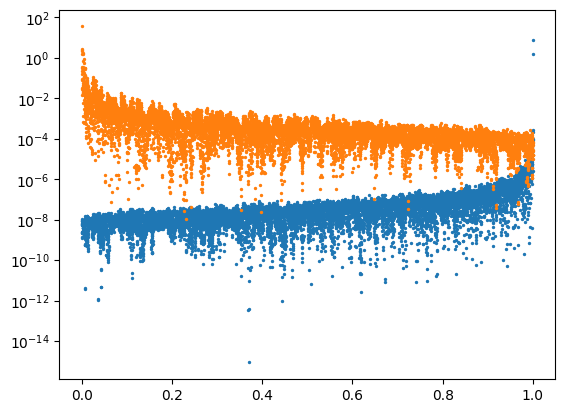

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.linspace(0,1,len(LinearOperator[0])), abs(LinearOperator[-1]), s = 2)

ax.scatter(np.linspace(0,1,len(LinearOperator[0])), abs(LinearOperator[0]), s = 2)
plt.yscale('log')

In [27]:
eigenvals_idx = np.where(abs((1j * eigs.eigenvalues).imag) <= 1e-5)[0]
eigenvals = np.round([-1j * eigs.eigenvalues[i] for i in eigenvals_idx],5)
eigenvals

array([ 36.35114-0.e+00j, -36.35114-0.e+00j,  31.87712+0.e+00j,
       -31.87712+0.e+00j,  35.79991-0.e+00j, -35.79991-0.e+00j,
        32.48818-1.e-05j, -32.48818-1.e-05j], dtype=complex64)

In [33]:
eigenvects = eigs.eigenvectors[eigenvals_idx]

In [34]:
eigenvects

tensor([[-2.6363e-05-3.2186e-06j, -2.6363e-05+3.2186e-06j,
         -1.3723e-04-1.9569e-05j,  ...,
          3.4338e-04+4.3853e-04j,  1.1479e-03+0.0000e+00j,
         -6.5491e-04+0.0000e+00j],
        [-1.0296e-06+2.5858e-05j, -1.0296e-06-2.5858e-05j,
          1.4385e-05+1.4115e-04j,  ...,
          1.5575e-04+1.9429e-04j,  5.1349e-04+0.0000e+00j,
         -2.9276e-04+0.0000e+00j],
        [-2.2121e-07+1.1601e-05j, -2.2121e-07-1.1601e-05j,
         -2.6488e-07-2.3500e-05j,  ...,
          2.3406e-04-3.4804e-05j, -1.2713e-03+0.0000e+00j,
          3.5002e-04+0.0000e+00j],
        ...,
        [ 4.1045e-07-1.7308e-06j,  4.1045e-07+1.7308e-06j,
          2.4023e-06+2.7276e-06j,  ...,
          5.4608e-03-1.3204e-02j, -4.4312e-03+0.0000e+00j,
         -3.3219e-03+0.0000e+00j],
        [ 1.6225e-07-3.4621e-07j,  1.6225e-07+3.4621e-07j,
          1.8978e-07-1.9249e-06j,  ...,
         -3.4027e-04-3.4232e-04j, -3.1380e-03+0.0000e+00j,
          2.6116e-03+0.0000e+00j],
        [-7.7089e-06-1

In [52]:
dm = VectorField(mesh=mesh)
dm.devectorize(eigenvects[4])
dm.values

array([[ 2.5708676e-05+2.0907766e-05j,  2.5708676e-05-2.0907766e-05j,
         6.5682980e-07+3.8405782e-05j],
       [ 6.5682980e-07-3.8405782e-05j,  3.9836632e-06-4.1388565e-05j,
         3.9836632e-06+4.1388565e-05j],
       [ 4.7226295e-05-2.6627711e-05j,  4.7226295e-05+2.6627711e-05j,
        -7.8890269e-05-1.6075803e-05j],
       ...,
       [-5.5045635e-04+4.6437662e-04j, -5.3489138e-04+2.1416321e-04j,
        -5.3489138e-04-2.1416321e-04j],
       [-5.2558497e-04+0.0000000e+00j,  3.2533723e-04+0.0000000e+00j,
        -5.8768748e-04-8.7916048e-04j],
       [-5.8768748e-04+8.7916048e-04j,  1.0235233e-04+0.0000000e+00j,
         5.3810171e-04+0.0000000e+00j]], dtype=complex64)

In [53]:
field_Hd = 1e3*dm.values.real.T #-(Hd.values.T + H0.values.T)
field_Hd

array([[ 0.02570868,  0.00065683,  0.04722629, ..., -0.55045635,
        -0.525585  , -0.5876875 ],
       [ 0.02570868,  0.00398366,  0.04722629, ..., -0.53489137,
         0.32533723,  0.10235233],
       [ 0.00065683,  0.00398366, -0.07889027, ..., -0.53489137,
        -0.5876875 ,  0.53810173]], dtype=float32)

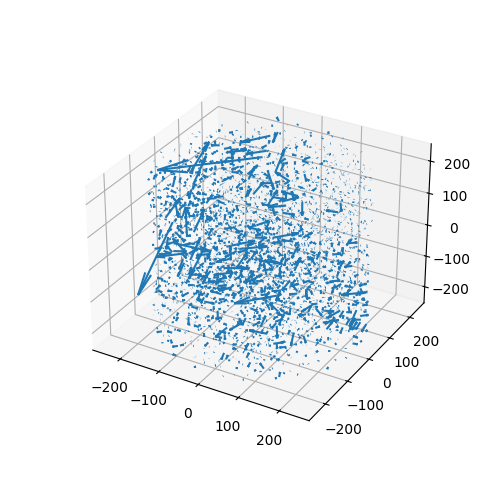

In [54]:
%matplotlib inline
%matplotlib widget 

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(projection="3d") 

ax.quiver(
    centers[0],
    centers[1],
    centers[2],
    field_Hd[0],
    field_Hd[1],
    field_Hd[2],
    length=1,
)

plt.show()

In [48]:
Hd = mv(mm,_vector_M0[1])
Hd

NameError: name 'mm' is not defined

In [ ]:
H_demg = VectorField(dim=3, coordinates=mesh.coordinates, mesh=mesh)

In [ ]:
np.zeros(shape=(6,3))